In [ ]:
from google.colab import files
uploaded = files.upload()
!unzip df.zip

Saving df.zip to df.zip
Archive:  df.zip
  inflating: df.csv                  


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import datetime as dt

In [ ]:
df = pd.read_csv('df.csv',parse_dates=True,index_col='date')
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['amount'])
df.columns=['Value']

In [ ]:
df

,Value
date,
1993-01,7.021576e+05
1993-02,2.726925e+06
1993-03,4.730319e+06
1993-04,7.378368e+06
1993-05,1.168075e+07
...,...
1998-08,1.506393e+08
1998-09,1.482977e+08
1998-10,1.518896e+08


In [ ]:
df.shape

(72, 1)

Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [ ]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.8 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])
  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
  print(f"""AR({p}) Model\n
        df_train.shape = {df_train.shape}; df_test.shape = {df_test.shape}\n
        X_train.shape = {X_train.shape}; y_train.shape = {y_train.shape}\n
        {X_train.shape[0]} = {df_train.shape[0]} - 1[diff()] - 12[diff(12)] - {p}[p]\n
        X_test.shape = ({df_test.shape[0]}, {df_test.shape[1]-1})""")

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [ ]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.8 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  print(f"""MA({q}) Model\n
        res_train.shape = {res_train.shape}; res_test.shape = {res_test.shape}\n
        X_train.shape = {X_train.shape}; y_train.shape = {y_train.shape}\n
        {X_train.shape[0]} = {res_train.shape[0]} - {q}[q]\n
        X_test.shape = ({res_test.shape[0]}, {res_test.shape[1]-1})""")
  
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



In [ ]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

#Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

原始序列不是平稳的

In [ ]:
adf_check(df.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.1080536452267353
p-value : 0.7118495413181575
Number of Lags Used : 12
Number of Observations Used : 59
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



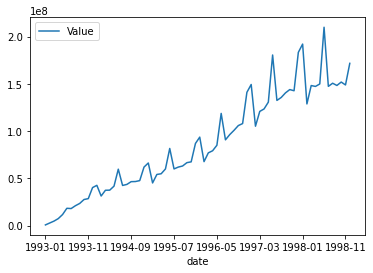

In [ ]:
df.plot()

log和一阶差分后仍然不平稳

In [ ]:
df_testing = pd.DataFrame(np.log(df.Value).diff())
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.2814795547752373
p-value : 0.6376022750380745
Number of Lags Used : 12
Number of Observations Used : 58
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



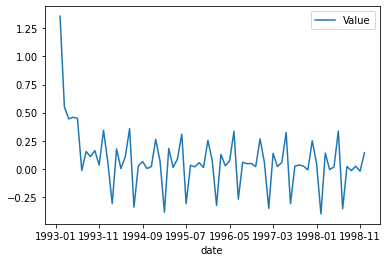

In [ ]:
df_testing.plot()

去除季节性之后是平稳的




In [ ]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.225226609716361
p-value : 7.807176920051058e-06
Number of Lags Used : 3
Number of Observations Used : 55
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


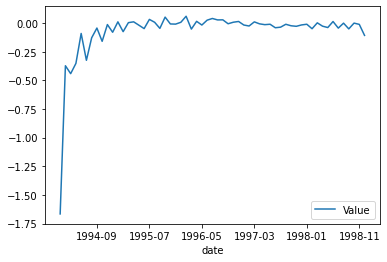

In [ ]:
df_testing.plot()

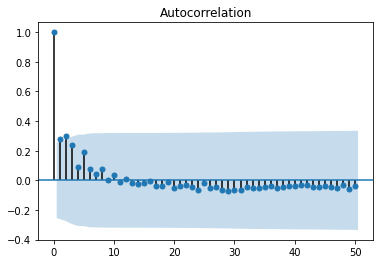

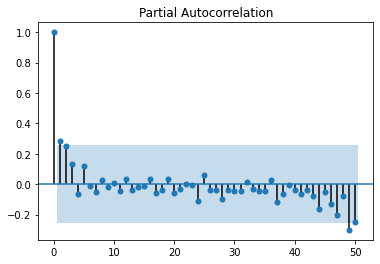

In [ ]:
ACF = plot_acf(df_testing.dropna(),lags=50)
PACF = plot_pacf(df_testing.dropna(),lags=50)

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [ ]:
df_testing.shape

(72, 1)

In [ ]:
df_testing.dropna().shape

(59, 1)

In [ ]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i
  
print(best_p)

AR(1) Model

        df_train.shape = (57, 2); df_test.shape = (15, 2)

        X_train.shape = (43, 1); y_train.shape = (43, 1)

        43 = 57 - 1[diff()] - 12[diff(12)] - 1[p]

        X_test.shape = (15, 1)
The RMSE is : 0.032388648408077265 , Value of p :  1
AR(2) Model

        df_train.shape = (57, 3); df_test.shape = (15, 3)

        X_train.shape = (42, 2); y_train.shape = (42, 1)

        42 = 57 - 1[diff()] - 12[diff(12)] - 2[p]

        X_test.shape = (15, 2)
The RMSE is : 0.03325009798919134 , Value of p :  2
AR(3) Model

        df_train.shape = (57, 4); df_test.shape = (15, 4)

        X_train.shape = (41, 3); y_train.shape = (41, 1)

        41 = 57 - 1[diff()] - 12[diff(12)] - 3[p]

        X_test.shape = (15, 3)
The RMSE is : 0.029558050939839802 , Value of p :  3
AR(4) Model

        df_train.shape = (57, 5); df_test.shape = (15, 5)

        X_train.shape = (40, 4); y_train.shape = (40, 1)

        40 = 57 - 1[diff()] - 12[diff(12)] - 4[p]

        X_test.shape = (1

In [ ]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

AR(7) Model

        df_train.shape = (57, 8); df_test.shape = (15, 8)

        X_train.shape = (37, 7); y_train.shape = (37, 1)

        37 = 57 - 1[diff()] - 12[diff(12)] - 7[p]

        X_test.shape = (15, 7)
The RMSE is : 0.027590310611580772 , Value of p :  7


In [ ]:
df_train.shape

(37, 9)

In [ ]:
df_test.shape

(15, 9)

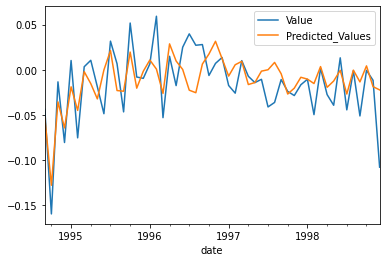

In [ ]:
df_c = pd.concat([df_train,df_test])
df_c.index = pd.DatetimeIndex(df_c.index)
df_c[['Value','Predicted_Values']].plot()

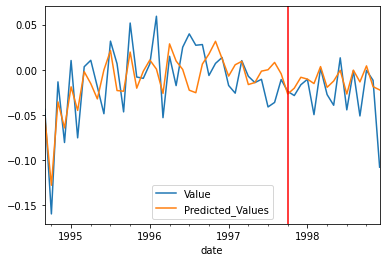

In [ ]:
test_size = 15
df_c[['Value','Predicted_Values']].plot()
plt.axvline(df_c.index[-test_size], color='r')

In [ ]:
df_c.shape

(52, 9)

注意，`df_c`是由`df_train`与`df_test`合并得到的，因为`df_train`是差分后的序列在`dropna`之后得到的序列，所以其长度`52=37+15`, 其中`37 = 57 - 1[diff()] - 12[diff(12)] - 7[p]`

Generating the residuals for MA

In [ ]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [ ]:
res.shape

(52, 1)

In [ ]:
res.head()

,Residuals
date,
1994-09-01,0.009048
1994-10-01,-0.031686
1994-11-01,0.022175
1994-12-01,-0.016185
1995-01-01,0.029131


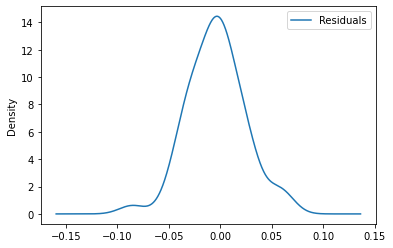

In [ ]:
res.plot(kind='kde')

#Step 3 : Fitting MA on Residuals

In [ ]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i
  
print(best_q)

MA(1) Model

        res_train.shape = (41, 2); res_test.shape = (11, 2)

        X_train.shape = (40, 1); y_train.shape = (40, 1)

        40 = 41 - 1[q]

        X_test.shape = (11, 1)
The RMSE is : 0.031984021565677506 , Value of q :  1
MA(2) Model

        res_train.shape = (41, 3); res_test.shape = (11, 3)

        X_train.shape = (39, 2); y_train.shape = (39, 1)

        39 = 41 - 2[q]

        X_test.shape = (11, 2)
The RMSE is : 0.032989430227765876 , Value of q :  2
MA(3) Model

        res_train.shape = (41, 4); res_test.shape = (11, 4)

        X_train.shape = (38, 3); y_train.shape = (38, 1)

        38 = 41 - 3[q]

        X_test.shape = (11, 3)
The RMSE is : 0.03408338236742454 , Value of q :  3
MA(4) Model

        res_train.shape = (41, 5); res_test.shape = (11, 5)

        X_train.shape = (37, 4); y_train.shape = (37, 1)

        37 = 41 - 4[q]

        X_test.shape = (11, 4)
The RMSE is : 0.03450430781256752 , Value of q :  4
MA(5) Model

        res_train.shape = (41

In [ ]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

MA(1) Model

        res_train.shape = (41, 2); res_test.shape = (11, 2)

        X_train.shape = (40, 1); y_train.shape = (40, 1)

        40 = 41 - 1[q]

        X_test.shape = (11, 1)
The RMSE is : 0.031984021565677506 , Value of q :  1
[[0.09510917]]
[-0.00053678]


In [ ]:
res_c = pd.concat([res_train,res_test])

In [ ]:
res_c.head()

,Residuals,Shifted_values_1,Predicted_Values
date,,,
1994-10-01,-0.031686,0.009048,0.000324
1994-11-01,0.022175,-0.031686,-0.003550
1994-12-01,-0.016185,0.022175,0.001572
1995-01-01,0.029131,-0.016185,-0.002076
1995-02-01,-0.030341,0.029131,0.002234


In [ ]:
df_c.Predicted_Values += res_c.Predicted_Values

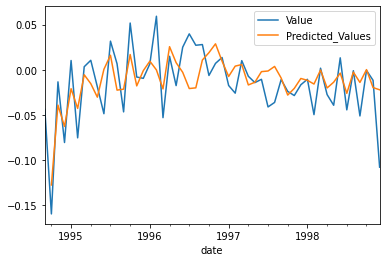

In [ ]:
df_c[['Value','Predicted_Values']].plot()

# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [ ]:
df_c.columns

Index(['Value', 'Shifted_values_1', 'Shifted_values_2', 'Shifted_values_3',
       'Shifted_values_4', 'Shifted_values_5', 'Shifted_values_6',
       'Shifted_values_7', 'Predicted_Values'],
      dtype='object')

In [ ]:
print(df_c.shape)
print(df.shape)

(52, 9)
(72, 1)


$$(1-B^{12})(1-B)\log{y_t} = x_t$$
$$(1 - B - B^{12} + B^{13})\log{y_t} = x_t$$
$$\log{y_t} - B\log{y_t} - B^{12}\log{y_t} + B^{13}\log{y_t} = x_t$$
$$\log{y_t} = x_t + B\log{y_t} + B^{12}(1-B)\log{y_t}$$
$$y_t = \exp(x_t + B\log{y_t} + B^{12}(1-B)\log{y_t})$$
$$y_t = \exp(x_t + B\log{y_t} + B^{12}\nabla  \log{y_t})$$

In [ ]:
df_c.Value += np.log(df).shift(1).Value
df_c.Value += np.log(df).diff().shift(12).Value
df_c.Predicted_Values += np.log(df).shift(1).Value 
df_c.Predicted_Values += np.log(df).diff().shift(12).Value
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [ ]:
df_c.head()

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Shifted_values_6,Shifted_values_7,Predicted_Values
date,,,,,,,,,
1994-09-01,4.647984e+07,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,-1.665408,NaN
1994-10-01,4.661549e+07,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,-0.372616,4.813179e+07
1994-11-01,4.759123e+07,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,-0.441680,4.638252e+07
1994-12-01,6.190363e+07,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,-0.352188,6.301268e+07
1995-01-01,6.624558e+07,-0.080443,-0.013330,-0.159458,-0.043756,-0.128964,-0.325125,-0.090902,6.421018e+07


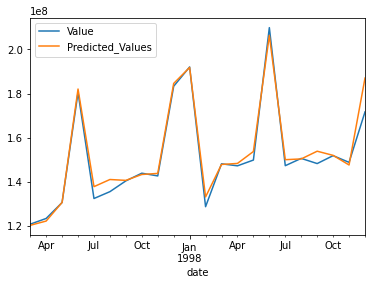

In [ ]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()